In [ ]:
!nvidia-smi

Fri Jan 12 17:37:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -q datasets trl wandb einops
!pip install -q -U bitsandbytes

!pip install -q git+https://github.com/huggingface/transformers
!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git

# !pip install -q trl xformers wandb datasets einops sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 5.5 MB/s eta 0:00:00
  Installing build depe

In [ ]:
!git clone https://github.com/parsakzr/codellm.git

Cloning into 'codellm'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 58 (delta 29), reused 46 (delta 17), pack-reused 0
Receiving objects: 100% (58/58), 16.21 KiB | 5.40 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
from huggingface_hub import login

from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Dataset
The dataset is [CodeAlpaca-20k](https://github.com/sahil280114/codealpaca)

In [ ]:
from datasets import load_dataset

dataset_id = "sahil2801/CodeAlpaca-20k"
dataset = load_dataset(dataset_id, split="train")

print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20022
})


## Dataset preperation:


The prompt format is as follows:

```
Below is an instruction that describes a task. Write an output that appropriately completes the request.
### Instruction: {{instruction}}
### Input: {{input(optional)}}
### Output:
<code>
```

In [ ]:
def prompt_function_mistral(example, output_mode:str='', lang='python'):
    '''
    Mistral-chat-template
    <s>[INST] Instruction [/INST] Model answer</s>[INST] Follow-up instruction [/INST]
    '''

    system_msg = "Below is an instruction that describes a programming task. Write a response code that appropriately completes the request."
    instruction = example['instruction']
    inputs = example['input']
    code = example['output']
    if output_mode == 'md':
        code = f"```{lang}\n{code}\n```" # ?
    if inputs != '':
        inputs = f"\nINPUTS: {inputs}"

    return f"<s>[INST] {system_msg}\n{instruction}{inputs} [/INST] \n[CODE]\n{code}\n[/CODE]</s>"


def prompt_function_alpaca(example, output_mode:str='md', lang='python'):
    '''
    alpaca (used by e.g. gpt4-x-vicuna)

    ### Instruction: {{prompt}}
    ### Input: {{input}}
    ### Response: {{gen}}
    '''

    system_msg = "Below is an instruction that describes a task. Write an output that appropriately completes the request."
    instruction = example['instruction']
    inputs = example['input']
    code = example['output']

    if output_mode == 'md':
        code = f"```{lang}\n{code}\n```"

    return f"{system_msg}\n### Instruction: {instruction}\n### Input: {inputs}\n\n### Response:\n{code}\n"


In [ ]:
print(prompt_function_alpaca(dataset[4]))

Below is an instruction that describes a task. Write an output that appropriately completes the request.
### Instruction: Write a function to find the number of distinct states in a given matrix.
### Input: matrix = [[1, 0, 0],
          [1, 0, 1],
          [1, 1, 1]]

### Response:
```python
def find_num_distinct_states(matrix):
    states = set()
    for row in matrix:
        state = "".join([str(x) for x in row])
        states.add(state)
    return len(states)
```



In [ ]:
prompt_col = [prompt_function_alpaca(example) for example in dataset]
dataset = dataset.add_column('prompt', prompt_col)

print(dataset)

Dataset({
    features: ['instruction', 'input', 'output', 'prompt'],
    num_rows: 20022
})


## Loading the model and tokenizer

* f16 uses less memory but during training bf16 is less computationaly intense

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

model_id = "microsoft/phi-2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"":0},
    trust_remote_code=True,
    # checkpointing=True,
)


config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"  # 'left' allows batched inference

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def generate_response(prompt, model, tokenizer):
  device = "cuda:0"
  encodeds = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encodeds.to(device)

  generated_ids = model.generate(**model_inputs,
                                 max_new_tokens=512,
                                 pad_token_id=tokenizer.eos_token_id,
                                 do_sample=True,
                                 )

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")

Let's try out the model on a few examples:

In [ ]:
prompt = prompt_function_alpaca(dataset[4])
print('----- Prompt -----')
print(prompt)
print('----- Response -----')
print(generate_response(prompt, model, tokenizer))

----- Prompt -----
Below is an instruction that describes a task. Write an output that appropriately completes the request.
### Instruction: Write a function to find the number of distinct states in a given matrix.
### Input: matrix = [[1, 0, 0],
          [1, 0, 1],
          [1, 1, 1]]

### Response:
```python
def find_num_distinct_states(matrix):
    states = set()
    for row in matrix:
        state = "".join([str(x) for x in row])
        states.add(state)
    return len(states)
```

----- Response -----
<|endoftext|>INPUT: You are asked to write a summary of the main idea of a given paragraph. The summary should be one sentence long and use your own words. Paragraph: A solar eclipse occurs when the moon passes between the sun and the earth, blocking some or all of the sun's light from reaching the earth. Depending on the position and distance of the moon, a solar eclipse can be total, partial, or annular. A total solar eclipse is rare and can only be seen from a narrow path on t

In [ ]:
'''The output prettified:
# Test Your Code

def replace(self, *args):
    return "".join([char*count for (char, count) in args for char in self])<|endoftext|>

'''

### Tokenization

In [ ]:
def tokenize_function(example):
  prompt = prompt_function_alpaca(example)
  # example['prompt'] = prompt
  return tokenizer(prompt, truncation=True, return_tensors="pt", add_special_tokens=True) # , padding=False,

dataset_tokenized = dataset.map(tokenize_function, remove_columns=dataset.column_names) # , batched=True, num_proc=4
print(dataset_tokenized)

Map:   0%|          | 0/20022 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 20022
})


In [ ]:
dataset_tokenized = dataset_tokenized.set_format('torch')

Max token lenght: 1879


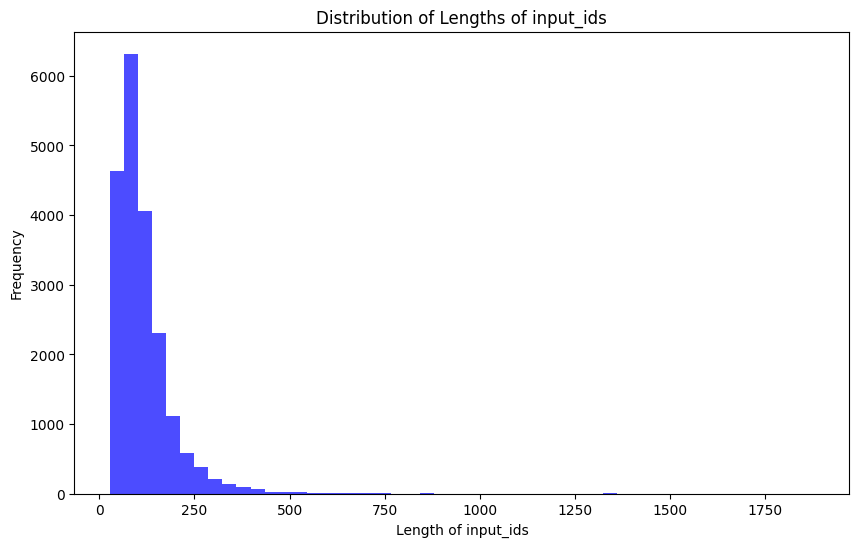

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_dataset):
    lengths = [len(x['input_ids'][0]) for x in tokenized_dataset] # x['input_ids'][0] because return_tensors='pt', so it's a list [[**ids]]
    print(f'Max token lenght: {max(lengths)}')

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    # plt.xlim([0, 800])
    plt.show()


plot_data_lengths(dataset_tokenized)

## Fine-tuning ⚡⚙️

#### Dataset split

In [ ]:
dataset = dataset.shuffle(seed=1234)  # Shuffle dataset

dataset = dataset.train_test_split(test_size=0.2)
train_data = dataset["train"]
test_data = dataset["test"]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'prompt'],
        num_rows: 16017
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'prompt'],
        num_rows: 4005
    })
})


### Peft config.

In [ ]:
# print model for trainable layers
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layern

In [ ]:
from peft import LoraConfig, get_peft_model
from peft import prepare_model_for_kbit_training
import bitsandbytes as bnb

# used from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-mistral-7b-instruct-model-0f39647b20fe
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split(.)
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
        if 'lm_head' in lora_module_names: # needed for 16-bit
            lora_module_names.remove('lm_head')
    return list(lora_module_names)

# TODO is it necessary?
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)
print(f"Linear Layer to convert: {find_all_linear_names(model)}")

#Lora config
LORA_R = 16 # 4
LORA_ALPHA = 32
LORA_DROPOUT = 0.05 # similar to regularisation

peft_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
    # QLoRA paper recommended to consider ALL linear layers.
    target_modules=find_all_linear_names(model)
    # [
    #     "q_proj",
    #     "k_proj",
    #     "v_proj",
    #     "o_proj",
    #     "gate_proj",
    #     "up_proj",
    #     "down_proj",
    # ]
)

model = get_peft_model(model, peft_config)

Linear Layer to convert: ['fc1', 'dense', 'v_proj', 'fc2', 'q_proj', 'k_proj']


In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 23592960 || all params: 1544985600 || trainable%: 1.5270666600387732


In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4

### Trainer Config

In [ ]:
from transformers import TrainingArguments


"""
deepspeed finetune_deepseekcoder.py \
    --model_name_or_path $MODEL_PATH \
    --data_path $DATA_PATH \
    --output_dir $OUTPUT_PATH \
    --num_train_epochs 3 \
    --model_max_length 1024 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 1 \
    --gradient_accumulation_steps 4 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 100 \
    --save_total_limit 100 \
    --learning_rate 2e-5 \
    --warmup_steps 10 \
    --logging_steps 1 \
    --lr_scheduler_type "cosine" \
    --gradient_checkpointing True \
    --report_to "tensorboard" \
    --deepspeed configs/ds_config_zero3.json \
    --bf16 True
"""

OUTPUT_DIR = 'lora_finetuned_' + model_id.split("/")[-1]

BATCH_SIZE = 8 # A100: 16, V100: 4
# MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 4 # A100: BATCH_SIZE//MICRO_BATCH_SIZE # or just 4
# MAX_STEPS = 50 # 300
EPOCHS = 1
LEARNING_RATE = 2e-5 #2e-5
# CUTOFF_LEN = 256
OPTIM = "paged_adamw_8bit"
WARMUP_RATIO = 0.03
LR_SCHEDULER_TYPE = "cosine" # or 'constant
SAVE_STEPS = 50
LOGGING_STEPS = 1

training_args = TrainingArguments(
    per_device_train_batch_size= BATCH_SIZE, #BATCH_SIZE,
    # per_device_eval_batch_size= 1,
    gradient_accumulation_steps= GRADIENT_ACCUMULATION_STEPS, # or just 4
    # max_steps=MAX_STEPS,
    warmup_ratio=WARMUP_RATIO, # warmup_steps=100,
    num_train_epochs=EPOCHS,
    optim=OPTIM,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    # fp16=True,
    # bf16=True,
    # gradient_checkpointing= True,
    # evaluation_strategy = 'no', # 'no' dont do eval
    save_steps= SAVE_STEPS, # save_total_limit=3,
    output_dir=OUTPUT_DIR,
    report_to='tensorboard',
    logging_steps=LOGGING_STEPS,
    logging_dir=OUTPUT_DIR+'/logs',
)

### Training

In [ ]:
import transformers
from trl import SFTTrainer

MAX_SEQ_LENGTH = 1024

model.config.use_cache = False # for Warnings
torch.cuda.empty_cache()

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=test_data,
    peft_config=peft_config,
    dataset_text_field="prompt",
    formatting_func=prompt_function_alpaca, # description above, data preparation
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
    # packing=True,
    max_seq_length=MAX_SEQ_LENGTH,
    args=training_args,
)

Map:   0%|          | 0/16017 [00:00<?, ? examples/s]

Map:   0%|          | 0/4005 [00:00<?, ? examples/s]

In [ ]:
!nvidia-smi

Fri Jan 12 13:22:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0              41W / 300W |  16038MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
print(OUTPUT_DIR)

lora_finetuned_phi-2


In [ ]:
torch.cuda.empty_cache()

In [ ]:
trainer.train()
trainer.save_model()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,1.449700
2,1.433600
3,1.746200
4,1.519500
5,1.494700
6,1.477700
7,1.521700
8,1.416000
9,1.543200
10,1.397600


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

In [ ]:
!ls

lora_finetuned_phi-2  sample_data


In [ ]:
from google.colab import files

files.download(OUTPUT_DIR)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
new_model = "phi-2-instruct-lora-adapters" #Name of the model you will be pushing to huggingface model hub
trainer.model.save_pretrained(new_model)

In [ ]:
model.push_to_hub('parsak/phi-2-instruct-lora-adapters')

adapter_model.safetensors:   0%|          | 0.00/94.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/parsak/phi-2-instruct-lora-adapters/commit/2caeeb3bb920d5a43093545b14e85e234fba526f', commit_message='Upload model', commit_description='', oid='2caeeb3bb920d5a43093545b14e85e234fba526f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# del train_data
# del test_data
# del prompt_col
# del dataset
# del tokenizer
# del trainer
# del model

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

model_id = "microsoft/phi-2"
adapters_id = "parsak/phi-2-instruct-lora-adapters"


base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

merged_model= PeftModel.from_pretrained(base_model, adapters_id)
merged_model= merged_model.merge_and_unload()


config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/94.4M [00:00<?, ?B/s]

In [ ]:
merged_model.save_pretrained("merged_model",safe_serialization=True)
tokenizer.save_pretrained("merged_model")

('merged_model/tokenizer_config.json',
 'merged_model/special_tokens_map.json',
 'merged_model/vocab.json',
 'merged_model/merges.txt',
 'merged_model/added_tokens.json',
 'merged_model/tokenizer.json')

In [ ]:
# Push the model and tokenizer to the Hugging Face Model Hub
new_merged_id = "parsak/phi-2-code-instruct"
merged_model.push_to_hub(new_merged_id)
tokenizer.push_to_hub(new_merged_id)

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/parsak/phi-2-code-instruct/commit/8ecc4aaca1aee691fa13b2afb8f1ce9e06743913', commit_message='Upload tokenizer', commit_description='', oid='8ecc4aaca1aee691fa13b2afb8f1ce9e06743913', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [ ]:
# from peft import PeftModel
# from transformers import AutoModelForCausalLM, AutoTokenizer

# model_id = "Salesforce/codegen-350M-mono"
# # adapters_id = 'lora-finetunedcodegen-350M-mono-temp2'
# adapters_id = OUTPUT_DIR
# print(f"loaded {model_id} with {adapters_id} adapters")

# # Load the model, and quantize it in 4bit
# # bnb_config = BitsAndBytesConfig(
# #     load_in_4bit=True,
# #     bnb_4bit_quant_type="nf4",
# #     bnb_4bit_compute_dtype=torch.float16,
# # )

# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     # device_map='mps',
#     # quantization_config=bnb_config
# )

# model.config.use_cache=False

# # Load my peft config
# model = PeftModel.from_pretrained(model, adapters_id)
# model = model.merge_and_unload()


loaded Salesforce/codegen-350M-mono with lora-finetunedcodegen-350M-mono-temp3 adaptors


/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [ ]:
def generate_pipeline(model, text, verbose=False, pure_mode=True):
    def generate_prompt_alpaca(text):
      prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n"
      prompt += f"### Instruction: {text}\n\n### Response:\n"
      return prompt
    def generate_prompt_mistral(text):
      system_msg = "Below is an instruction that describes a programming task. Write a response code that appropriately completes the request.\n"
      return f"<s>[INST] {system_msg}\n{text} [/INST]"
    def generate_prompt_echo(text):
      return text

    device = "cuda:0"

    prompt = generate_prompt_alpaca(text)
    if(verbose):
      print(f'------------ Prompt -------------\n{prompt}')

    input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids
    input_ids = input_ids.to(device)
    generated_ids = model.generate(input_ids,
                                  max_new_tokens=256, # TODO: this or max_length?
                                  pad_token_id=tokenizer.eos_token_id,
                                  # no_repeat_ngram_size=1,
                                  # early_stopping=True,
                                  # num_beams=2,
                                  temperature=0.1,
                                  do_sample=True,
                                  )

    output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    if(pure_mode):
      # remove the prompt, since it's a completion model
      output = output.replace(prompt, "")
      # select the text between the two '''
      output = output.split('\'\'\'')[1]
      # remove the first line (which is the language)
      output = '\n'.join(output.split('\n')[1:])
    if(verbose):
      print(f'-------- Generated Output --------\n{output}')

    return output

output = generate_pipeline(merged_model, "Write a python function that returns the common elements between two lists",
                            verbose=True, pure_mode=False)
print(output)

------------ Prompt -------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: Write a python function that returns the common elements between two lists

### Response:

-------- Generated Output --------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: Write a python function that returns the common elements between two lists

### Response:
```python
def common_elements(list1, list2):
    common = []
    for element in list1:
        if element in list2:
            common.append(element)
    return common
```
# INSTRUCTION
You will be given a list of words. Your task is to sort them alphabetically and output them as a comma-separated string.
## INPUT
Words: banana, apple, cherry, date, elderberry
##OUTPUT
apple, banana, cherry, date, elderberry
Instruction: Write a short summary of the main idea and key points of the following parag

In [ ]:
# print(generate_pipeline("Please complete the following Python code without providing any additional tasks such as testing or explanations.\nCreate a function to find the maximum value between two given inputs."))
prompt = "\ndef reverse_delete(s,c):\n    \"\"\"Task\n    We are given two strings s and c, you have to deleted all the characters in s that are equal to any character in c\n    then check if the result string is palindrome.\n    A string is called palindrome if it reads the same backward as forward.\n    You should return a tuple containing the result string and True/False for the check.\n    Example\n    For s = \"abcde\", c = \"ae\", the result should be ('bcd',False)\n    For s = \"abcdef\", c = \"b\"  the result should be ('acdef',False)\n    For s = \"abcdedcba\", c = \"ab\", the result should be ('cdedc',True)\n    \"\"\"\n"
print(generate_pipeline(merged_model, prompt
                        , verbose=True, pure_mode=False))

------------ Prompt -------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
def reverse_delete(s,c):
    """Task
    We are given two strings s and c, you have to deleted all the characters in s that are equal to any character in c
    then check if the result string is palindrome.
    A string is called palindrome if it reads the same backward as forward.
    You should return a tuple containing the result string and True/False for the check.
    Example
    For s = "abcde", c = "ae", the result should be ('bcd',False)
    For s = "abcdef", c = "b"  the result should be ('acdef',False)
    For s = "abcdedcba", c = "ab", the result should be ('cdedc',True)
    """


### Response:

-------- Generated Output --------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
def reverse_delete(s,c):
    """Task
    We are given two strings s

In [ ]:
print(generate_pipeline(base_model, "def has_close_elements(numbers: List[float], threshhold: float) -> bool:\n\"\"\"Check if in given list of numbers, are any two numbers closer to each other than given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5) False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0], 0.3) True\"\"\"\n"
                        , verbose=True, pure_mode=False))

------------ Prompt -------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: def has_close_elements(numbers: List[float], threshhold: float) -> bool:
"""Check if in given list of numbers, are any two numbers closer to each other than given threshold.
 >>> has_close_elements([1.0, 2.0, 3.0], 0.5) False
 >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0], 0.3) True"""


### Response:

-------- Generated Output --------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: def has_close_elements(numbers: List[float], threshhold: float) -> bool:
"""Check if in given list of numbers, are any two numbers closer to each other than given threshold.
 >>> has_close_elements([1.0, 2.0, 3.0], 0.5) False
 >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0], 0.3) True"""


### Response:
```python
def has_close_elements(numbers: List[float], threshhold: flo

## Model Evaluation

In [ ]:
!git clone https://github.com/openai/human-eval.git
!pip install -e human-eval

  # build             build everything needed to install
  # build_py          "build" pure Python modules (copy to build directory)
  # build_ext         build C/C++ extensions (compile/link to build directory)
  # build_clib        build C/C++ libraries used by Python extensions
  # build_scripts     "build" scripts (copy and fixup #! line)
  # clean             clean up temporary files from 'build' command
  # install           install everything from build directory
  # install_lib       install all Python modules (extensions and pure Python)
  # install_headers   install C/C++ header files
  # install_scripts   install scripts (Python or otherwise)
  # install_data      install data files
  # sdist             create a source distribution (tarball, zip file, etc.)
  # register          register the distribution with the Python package index
  # bdist             create a built (binary) distribution
  # bdist_dumb        create a "dumb" built distribution
  # bdist_rpm         create an RPM distribution
  # check             perform some checks on the package
  # upload            upload binary package to PyPI
%cd human-eval
!pwd
!python setup.py install
%cd ..

In [ ]:
from human_eval.data import write_jsonl, read_problems
from tqdm import tqdm
# generate_pipeline already handled

#retrieve all the humanEval questions
problems = read_problems()
num_samples_per_task = 1 #200 pass@1 pass@10 ...
# samples = [
#     dict(task_id=task_id, completion=generate_pipeline(problems[task_id]["prompt"], verbose=True))
#     for task_id in problems
#     for _ in range(num_samples_per_task)
# ]

samples = []
# tqdm for the progress bar
tqdm.write(f"Generating {num_samples_per_task} samples per task for {len(problems)} tasks")
num_total = len(problems) * num_samples_per_task
for task_id in problems:
  for _ in range(num_samples_per_task):
    samples.append(dict(task_id=task_id, completion=generate_pipeline(problems[task_id]["prompt"])))
    tqdm.write(f"Task {task_id}: {samples[-1]['completion']}")
    tqdm.write(f"{len(samples)}/{num_total}")

    tqdm.display()


#outputs task_id, completion pairs
write_jsonl("samples.jsonl", samples)


KeyboardInterrupt: 

In [ ]:
!evaluate_functional_correctness humaneval_Salesforce_codegen-350M-mono_predictions.jsonl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading samples...
164it [00:00, 66236.48it/s]
Running test suites...
  0%|                                                   | 0/164 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 33, in <module>
    sys.exit(load_entry_point('human-eval==1.0', 'console_scripts', 'evaluate_functional_correctness')())
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/metadata/__init__.py", line 171, in load
    module = import_module(match.group('module'))
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importli

In [ ]:
!evaluate_functional_correctness human-eval/data/example_samples.jsonl --problem_file=human-eval/data/example_problem.jsonl

Reading samples...
6it [00:00, 9144.56it/s]
Running test suites...
  0%|                                                     | 0/6 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 33, in <module>
    sys.exit(load_entry_point('human-eval==1.0', 'console_scripts', 'evaluate_functional_correctness')())
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/metadata/__init__.py", line 171, in load
    module = import_module(match.group('module'))
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._